# Spiking-Phasor Integrator
Purpose: to have a spiking-phasor SSP integrate its input.

## Prelims

In [1]:
from numpy import *
from matplotlib.pyplot import *
from tqdm import tqdm
from phasorutils import *
from brian2 import *
from numpy import *
from matplotlib.pyplot import *
from spikingVSA import *
from copy import deepcopy
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import time

%load_ext autoreload
%autoreload 2

In [2]:
M = 1
N = 100
freq = 10.
ds = SparsePhaseMap(M=M, N=N, sparsity=1.)

## Dynamic SSP - Not Integration
This generates an SSP population for which the encoded value can be controlled dynamically.

In [3]:
# Spiking bundling
net = SpikingPhasorNet()

y = GenerateSP(N=N, C=ds.S[0], freq=freq); net.add_pop(y)
y1 = PhaseMultPop(N=N, freq=freq); net.add_pop(y1)
x = GenerateSP(N=N, C=ds.S[0], freq=freq); net.add_pop(x)
x1 = PhaseMultPop(N=N, freq=freq); net.add_pop(x1)

true_y1 = -2.5
net.fractional_bind(y, y1, true_y1)
true_x1 = 1.
net.fractional_bind(x, x1, true_x1)

In [4]:
# This function controls the value as a function of time.
def update_input(t):
    #if t>1000*ms:
    setattr(net.syns[0].br, net.syns[0].alpha_id, t/second - 4)
    setattr(net.syns[1].br, net.syns[1].alpha_id, t/second)

net.br.add(NetworkOperation(update_input, dt=10*ms))

In [5]:
net.run(4*second)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'pth_post = x_post * alpha559'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'pth_post = x_post * alpha164'
 [brian2.codegen.generators.base]


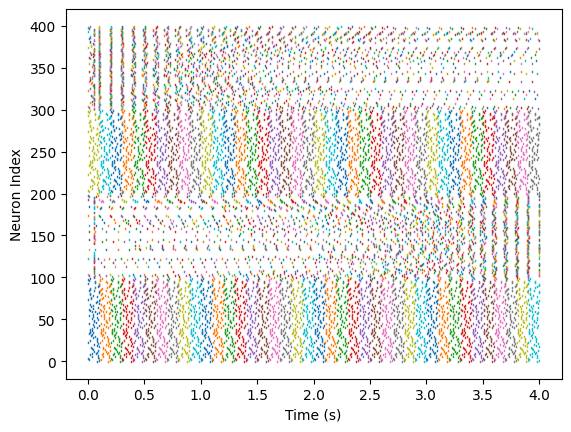

In [7]:
net.spike_raster()

### Look at a single time

In [8]:
xvals = linspace(-4, 4, 101)
true_x2 = 3.3
max_i, sims2 = spatial_similarity(y1, ds.S[0], xvals, start_time=true_x2)

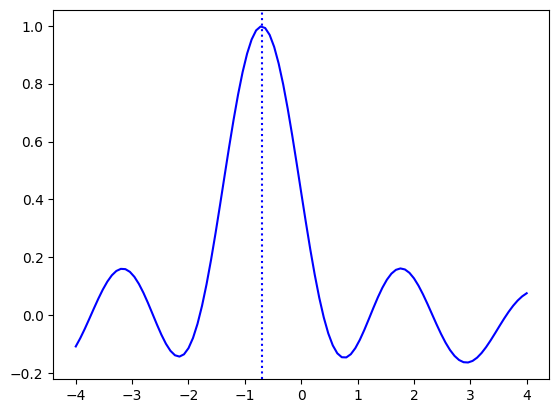

In [9]:
plot(xvals, sims2, 'b');
axvline(x=true_x2-4, ymin=0, ymax=1, color='b', ls=':');

### Plot value over time

In [10]:
n_samples = 101
yvals = linspace(-4, 0., n_samples)
xvals = linspace(0, 4., n_samples)
tvals = arange(0, 4., 1./freq)
fy = []
fx = []
for tt in tvals:
    max_i, sims = spatial_similarity(y1, ds.S[0], yvals, start_time=tt)
    fy.append(yvals[max_i])
    max_i, sims = spatial_similarity(x1, ds.S[0], xvals, start_time=tt)
    fx.append(xvals[max_i])

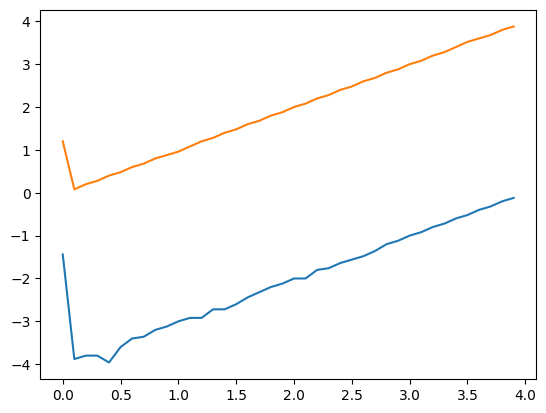

In [11]:
plot(tvals, fy);
plot(tvals, fx);

## Integrator

### Single neuron

In [43]:
N = 1
freq = 10.
ϕ = 0.05
S = array([exp(ϕ*2.j*pi)])

net = SpikingPhasorNet()

inp = GenerateSP(N=N, C=S, freq=freq); net.add_pop(inp)
y = SPIntegrator(N=N, freq=freq); net.add_pop(y)

net.integrate(inp, y)

In [44]:
defaultclock.dt = 1.*ms

In [45]:
net.run(2*second)

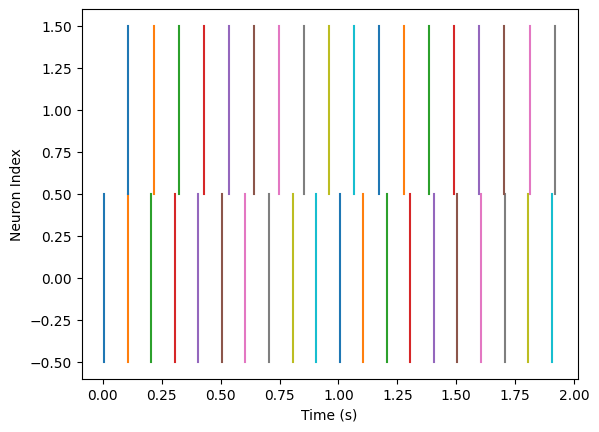

In [46]:
net.spike_raster()

### An SSP

In [3]:
N = 100
M = 1
freq = 5.
reset_time = 0.2
T = 5.  # simulation time
v = 1.  # set the velocity
ds = SparsePhaseMap(M=M, N=N, sparsity=1.)

net = SpikingPhasorNet()

# Create velocity input
reset_neuron = GenerateSpikes(N=1, indices=[0], times=[reset_time]); net.add_pop(reset_neuron)
inp = GenerateSP(N=N, C=ds.S[0], freq=freq); net.add_pop(inp)
V = PhaseMultPop(N=N, freq=freq); net.add_pop(V)
net.fractional_bind(inp, V, v/freq)  # synapse 0

# Integrator
y = SPIntegrator(N=N, freq=freq); net.add_pop(y)
net.integrate(V, y, 1.)  # synapse 1

net.reset(reset_neuron, y)

def update_input(t):
    v = 0.
    if t>=0.2*second and t<=2200*ms:
        v = 1./freq
    setattr(net.syns[0].br, net.syns[0].alpha_id, v)
    return v

net.br.add(NetworkOperation(update_input, dt=10*ms))

In [93]:
net.run(T*second)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'pth_post = x_post * alpha854'
 [brian2.codegen.generators.base]


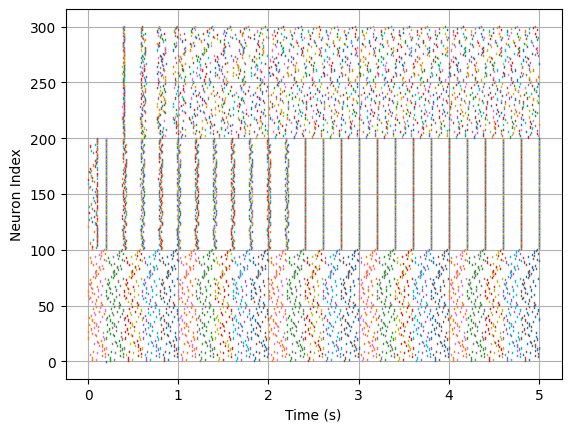

In [94]:
net.spike_raster()
grid('on');

In [89]:
xvals = linspace(-5, 5, 201)
max_i, sims2 = spatial_similarity(y, ds.S[0], xvals, start_time=4.7+reset_time)

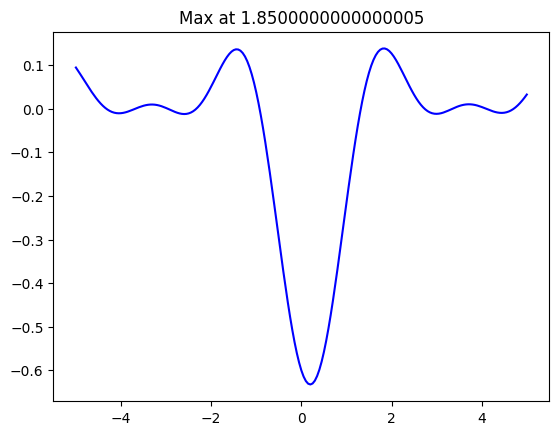

In [90]:
plot(xvals, sims2, 'b');
title(f'Max at {xvals[max_i]}');
#axvline(x=true_x2-4, ymin=0, ymax=1, color='b', ls=':');

WARNING    /Users/jorchard/Library/CloudStorage/Dropbox/research/TPAM/spikingVSA.py:60: RuntimeWarning: invalid value encountered in scalar divide
  m_sim = real(sum(v*conj(S[m]))) / linalg.norm(v) / linalg.norm(S[m])
 [py.warnings]


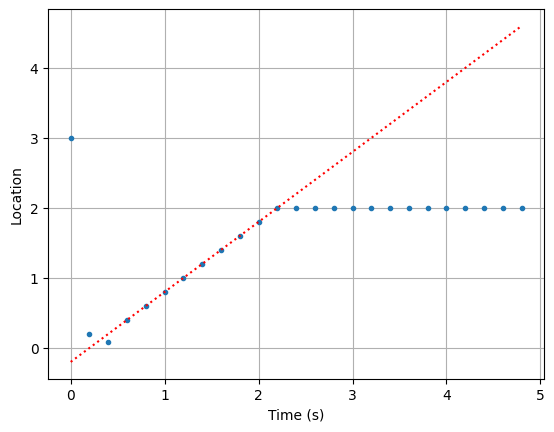

In [95]:
fy, tvals = y.decode_xt(ds.S[0], [0, 3])

plot(tvals, fy, '.');
plot(tvals, (tvals-0.2)*v, 'r:');
grid('on'); xlabel('Time (s)'); ylabel('Location');

In [54]:
ttvals = arange(0, T, 1./freq/10.)
velocity = [update_input(second*(tt)) for tt in ttvals]

In [55]:
sum(velocity)

20.2

## Integrating dynamic velocity

### Velocity function (and distance)

In [5]:
def vel_param(t, c, pause):
    L = 7.
    v = zeros_like(t)
    mask = t>=pause
    v = c[0]*sin((t-pause)*2*pi/L) * mask
    for k,cc in enumerate(c[1:]):
        v += cc*sin(2*k*(t-pause)*2*pi/L) * mask
    return array(v)

In [6]:
def dist(velo, ttvals):
    dt = ttvals[1] - ttvals[0]
    velocity = velo(ttvals)
    d = [0.]
    for vv in velocity[:-1]:
        d.append(d[-1]+vv*dt)
    return array(d)

In [7]:
freq = 10.
T = 5.  # simulation time
ttvals = arange(0, T, 1./freq/10.)

c = random.normal(size=(5,))
print(c)
vel = lambda t: vel_param(t,c,0.1)

[-1.00712182 -0.2395771   2.07618151  0.25958951  0.09052469]


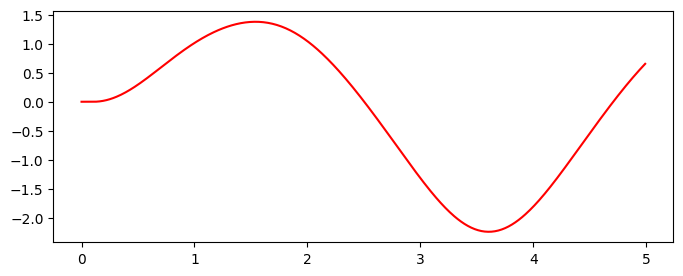

In [8]:
figure(figsize=(8,3))
plot(ttvals, dist(vel, ttvals), 'r');
#plot(ttvals, vel(ttvals));
#grid('on');
#legend(['Position', 'Velocity']);
savefig('position.pdf');

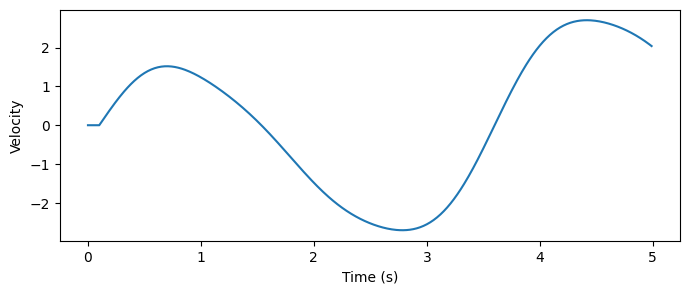

In [9]:
figure(figsize=(8,3))
plot(ttvals, vel(ttvals));
#grid('on');
xlabel('Time (s)'); ylabel('Velocity');
savefig('velocity.pdf');

### Integrate the velocity

In [10]:
N = 200
M = 1
#freq = 10.
reset_time = 0.1
#T = 5.  # simulation time
v = 1.  # set the velocity
ds = SparsePhaseMap(M=M, N=N, sparsity=1.)

net = SpikingPhasorNet()

# Input velocity
reset_neuron = GenerateSpikes(N=1, indices=[0], times=[reset_time]); net.add_pop(reset_neuron)
inp = GenerateSP(N=N, C=ds.S[0], freq=freq); net.add_pop(inp)
V = PhaseMultPop(N=N, freq=freq); net.add_pop(V)
net.fractional_bind(inp, V, v/freq)  # synapse 0

# Integrator
y = SPIntegrator(N=N, freq=freq); net.add_pop(y)
net.integrate(V, y)  # synapse 1

net.reset(reset_neuron, y)

def update_input(t):
    v = vel(t/second)/freq
    setattr(net.syns[0].br, net.syns[0].alpha_id, v)

net.br.add(NetworkOperation(update_input, dt=10*ms))

net.br.store()

In [96]:
net.total_neurons()

601

In [11]:
defaultclock.dt = 1.*ms

In [12]:
net.run(T*second)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'pth_post = (-0.5) + ((0.5 + (x_post * alpha976)) % 1)'
 [brian2.codegen.generators.base]


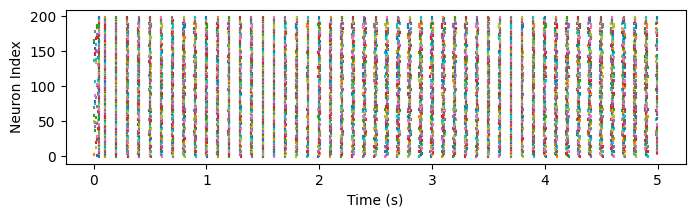

In [13]:
figure(figsize=(8,2))
V.spike_raster();
savefig('vel_spikes.pdf');

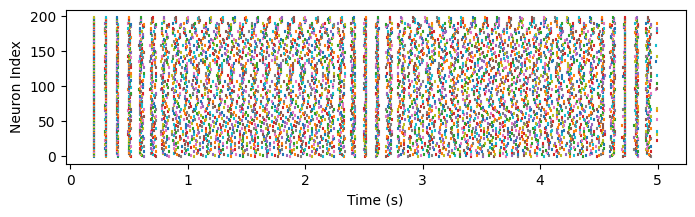

In [14]:
figure(figsize=(8,2))
y.spike_raster();
savefig('position_spikes.pdf');

### Resulting distance encoding

In [15]:
fy, tvals = y.decode_xt(ds.S[0], [-5,5], [0, 5])

WARNING    /Users/jorchard/Library/CloudStorage/Dropbox/research/TPAM/spikingVSA.py:41: RuntimeWarning: invalid value encountered in scalar divide
  m_sim = real(sum(v*conj(S[m]))) / linalg.norm(v) / linalg.norm(S[m])
 [py.warnings]


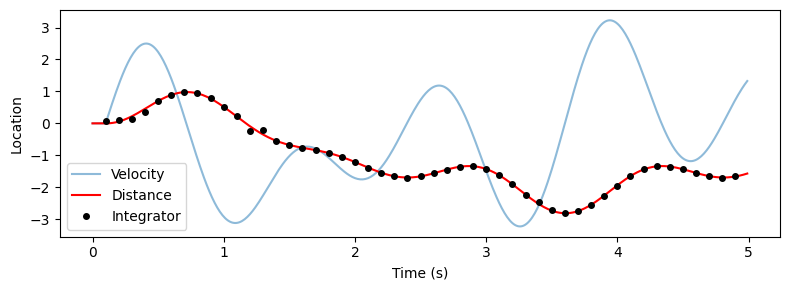

In [95]:
figure(figsize=(8,3))
plot(ttvals, vel(ttvals), alpha=0.5)
plot(ttvals, dist(vel, ttvals), 'r');
plot(tvals[1:], fy[1:], 'ko', ms=4);
legend(['Velocity', 'Distance', 'Integrator']);
#title('Position');
#grid('on');
xlabel('Time (s)'); ylabel('Location');
tight_layout();
savefig('integrator_results.pdf');

## Repeated runs

In [79]:
n_trials = 20

# Generate n_trial SSPs
ds = SparsePhaseMap(M=n_trials, N=N, sparsity=1.)

freq = 10.
T = 5.  # simulation time
ttvals = arange(0, T, 1./freq/10.)

fy_all = []
tvals_all = []
c_all = []
for trial in tqdm(range(n_trials)):
    
    net.br.restore()
    
    # Change the SSP
    inp.set_spikes(C=ds.S[trial])

    # Generate a random velocity signal
    c = random.normal(size=(5,))
    c_all.append(c)
    vel = lambda t: vel_param(t,c,0.1)
    
    net.run(T*second)

    fy, tvals = y.decode_xt(ds.S[trial], [-8,8], [0, 5])
    fy_all.append(fy)
    tvals_all.append(tvals)

  0%|                                                                                               | 0/20 [00:00<?, ?it/s]WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'pth_post = (-0.5) + ((0.5 + (x_post * alpha976)) % 1)'
 [brian2.codegen.generators.base]
  5%|████▎                                                                                  | 1/20 [00:06<02:00,  6.35s/it]WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'pth_post = (-0.5) + ((0.5 + (x_post * alpha976)) % 1)'
 [brian2.codegen.generators.base]
 10%|████████▋                                                                              | 2/20 [00:12<01:54,

 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 19/20 [02:00<00:06,  6.36s/it]WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'pth_post = (-0.5) + ((0.5 + (x_post * alpha976)) % 1)'
 [brian2.codegen.generators.base]
100%|██████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:06<00:00,  6.34s/it]


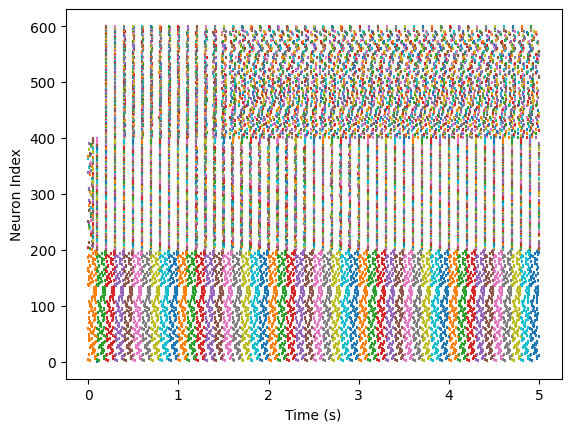

In [55]:
net.spike_raster()

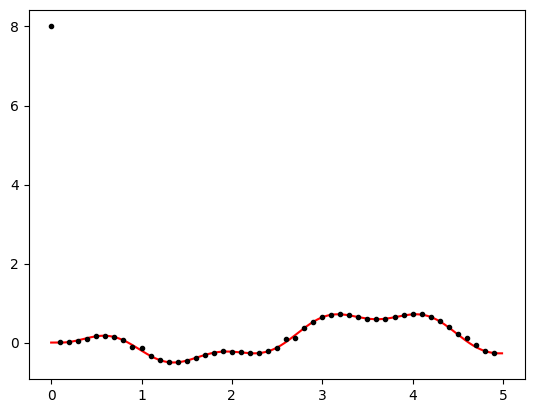

In [80]:
k = 10
vel = lambda t: vel_param(t,c_all[k],0.1)
plot(ttvals, dist(vel, ttvals), 'r')
plot(tvals_all[k], fy_all[k], 'k.');

In [87]:
err = []
tttvals = arange(0, T, 1./freq/100.)

for k in range(n_trials):
    
    vel = lambda t: vel_param(t,c_all[k],0.1)
    d = dist(vel, tttvals)
    
    err.append( interp(tvals_all[k][10:], tttvals, d) - fy_all[k][10:] )
    #err.append()

err = array(err)
fymat = array(fy_all)

In [100]:
sigma = std(err, axis=0)
fsigma = std(array(fymat[:,10:]), axis=0)

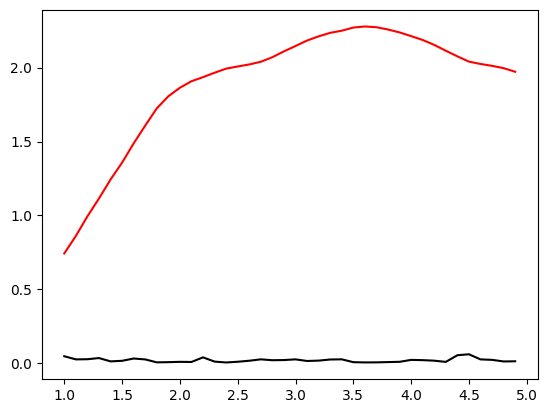

In [101]:
plot(tvals_all[0][10:], sigma, 'k');
plot(tvals_all[0][10:], fsigma, 'r');

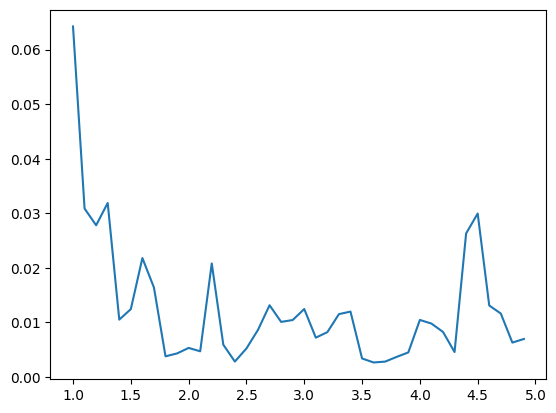

In [102]:
plot(tvals_all[0][10:], (sigma/fsigma));